# BERT base uncased MASK ALL usando TUDO
# mascarando o padrão e a sentença toda
## dissertação

# DEV datasets
### HypeNet - DEV
 - 49475 pares
    - True: 20.095% - 9942
    - False: 79.905% - 39533

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pandas as pd
import numpy as np
sys.path.append("/home/gabrielescobar/hyper_bert")
import nb_utils
sns.set(style="whitegrid", font_scale=1.5)
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
local = False

In [2]:
# server
# bert DEV en
if local:
    path_file_bert = "../../aaaaaaaa/test-mask-pattern/Weeds.json"
else:
    bert_mask = "../../en-model/bert-base-uncased_bert_score_2020-11-11_20:24:14_HypeNet_train/HypeNet_train.json"
    bert_mask_all = "../../en-model/bert-base-uncased_bert_score_maskall_2021-03-22_23:29:19/train/HypeNet_train.json"
    # alterar
    bert_mask_all_logsoftmax = "../../en-model/bert-base-uncased_bert_score_maskall_2021-03-23_12:26:19/train/HypeNet_train.json"

dfs_data = {}
dfs_data['mask'] = nb_utils.create_dataframe(json.load(open(bert_mask)), separator="\t")

dfs_data['maskAll'] = nb_utils.create_dataframe_maskAll(json.load(open(bert_mask_all)), separator="\t")
dfs_data['maskAll_LogSoft'] = nb_utils.create_dataframe_maskAll_pattern(json.load(open(bert_mask_all_logsoftmax)), separator="\t")

pattern_unique = dfs_data['mask']['pattern'].unique().tolist()
len_total_unique = dfs_data['mask']['len_total'].unique().tolist()

dfs_data['mask'] = nb_utils.logsumexp_normalization(dfs_data['mask'], 
                                                    len_list=len_total_unique, 
                                                    pattern_list=pattern_unique)

dfs_data['maskAll'] = nb_utils.logsumexp_normalization(dfs_data['maskAll'], 
                                                    len_list=len_total_unique, 
                                                    pattern_list=pattern_unique)


for mask_type, value in dfs_data.items():
    print(f"Mask= {mask_type} - DF all with OOV = {value[value['pattern'] == pattern_unique[0]].count()['hiponimo']}")

print("Processamento DEV pronto!")

Mask= mask - DF all with OOV = 49475
Mask= maskAll - DF all with OOV = 49475
Mask= maskAll_LogSoft - DF all with OOV = 49475
Processamento DEV pronto!


### DEV - inglês
#### Stats
 - Eixo X: Comprimento do par
 - Eixo Y: Quantidade de pares por comprimento

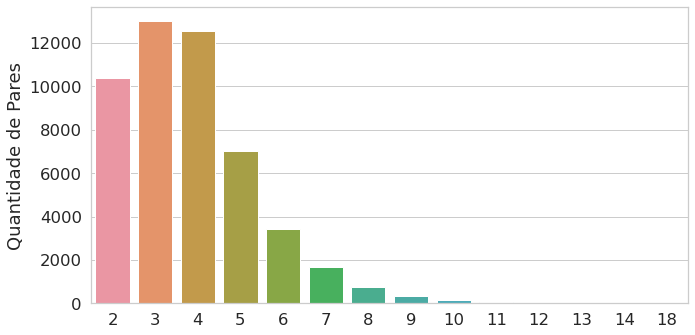

In [3]:
# Balanceamento quantidade de pares por comprimento
# Balanceamento df_with_oov
sns.set(style="whitegrid", font_scale=1.5)

df_with_oov = dfs_data['maskAll']
plt.figure(figsize=(10, 5))
df_with_oov_ratio = nb_utils.balanceamento(df_with_oov, patterns=pattern_unique,len_size=len_total_unique)
df_with_oov_ratio['total'] = df_with_oov_ratio['true'] + df_with_oov_ratio['false']
ax = sns.barplot(x="len_total", y="total", data=df_with_oov_ratio)
ax.set(xlabel="")
# ax.set_title(f"Number of pairs")
ax.set(ylabel="Quantidade de Pares")
# plt.savefig('DEV_numero_de_pares_por_comprimento_dataset_ingles.pdf')
plt.show()

### DEV - inglês
#### AP por padrão. Usado para selecionar os melhores padrões
#### Score é BERT dos tokens do padrão

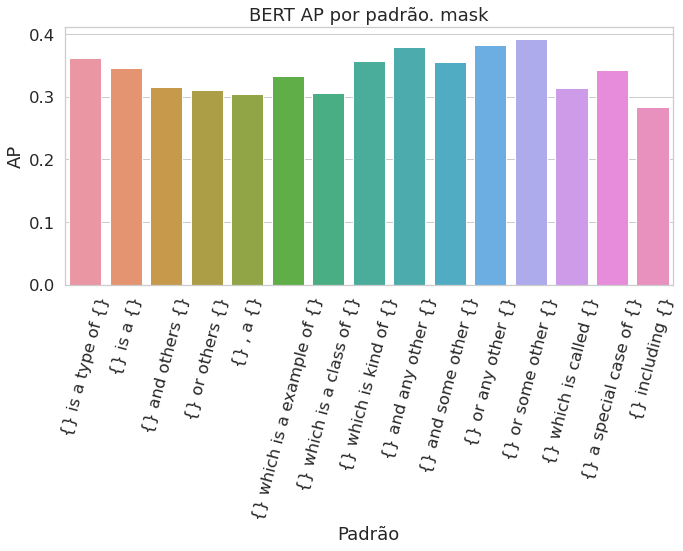

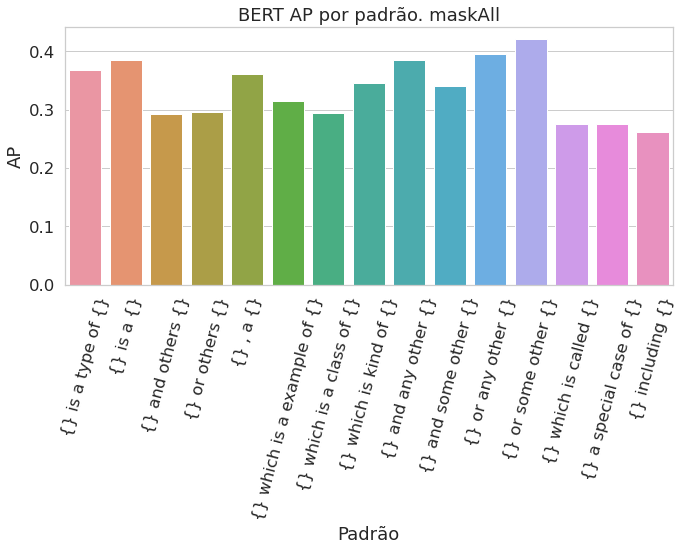

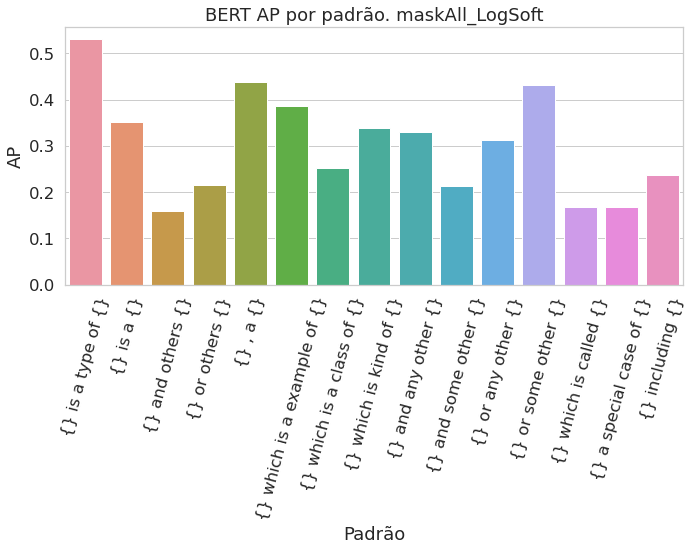

Melhores padrões usando BERT
mask
['{} or some other {}', '{} or any other {}', '{} and any other {}', '{} is a type of {}', '{} which is kind of {}', '{} and some other {}', '{} is a {}', '{} a special case of {}', '{} which is a example of {}', '{} and others {}', '{} which is called {}', '{} or others {}', '{} which is a class of {}', '{} , a {}', '{} including {}']
########

maskAll
['{} or some other {}', '{} or any other {}', '{} and any other {}', '{} is a {}', '{} is a type of {}', '{} , a {}', '{} which is kind of {}', '{} and some other {}', '{} which is a example of {}', '{} or others {}', '{} which is a class of {}', '{} and others {}', '{} a special case of {}', '{} which is called {}', '{} including {}']
########

maskAll_LogSoft
['{} is a type of {}', '{} , a {}', '{} or some other {}', '{} which is a example of {}', '{} is a {}', '{} which is kind of {}', '{} and any other {}', '{} or any other {}', '{} which is a class of {}', '{} including {}', '{} or others {}', '{} 

In [4]:
# AP por padrao DEV en
# AP por padrão
# IMPORTANTE mudar o key_sort
# dfs_data['mask'] 
# dfs_data['maskAll'] 
# dfs_data['maskAll_LogSoft']
best_pattern ={}
for mask_type, df_with_oov in dfs_data.items():
    if mask_type == "mask":
        column_sort = "score_final_log(z)"
    elif mask_type == "maskAll":
        column_sort = "score_final_log(z)"
    elif mask_type == "maskAll_LogSoft":
        column_sort = "score_pattern_mean"
    else:
        raise KeyError
        
    df_plot = nb_utils.compute_dataframe_AP_by_pattern(df_with_oov, key_sort=column_sort, 
                                                       pattern_list=pattern_unique)
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(data=df_plot, x='padrao', y='AP')
    ax.set(xlabel="Padrão")
    ax.set_title(f"BERT AP por padrão. {mask_type}")
    plt.xticks(rotation=75)
    plt.show()
    best_pattern[mask_type] = df_plot.sort_values(by='AP', ascending=False)['padrao'].tolist()

print(f"Melhores padrões usando BERT")
for mask_type, array_pattern in best_pattern.items():
    print(f"{mask_type}")
    print(array_pattern)
    print("########\n")

### DEV - inglês
#### AP variando os N melhores padrões, usando Average Rank e Min Rank
#### Score é BERT token pattern


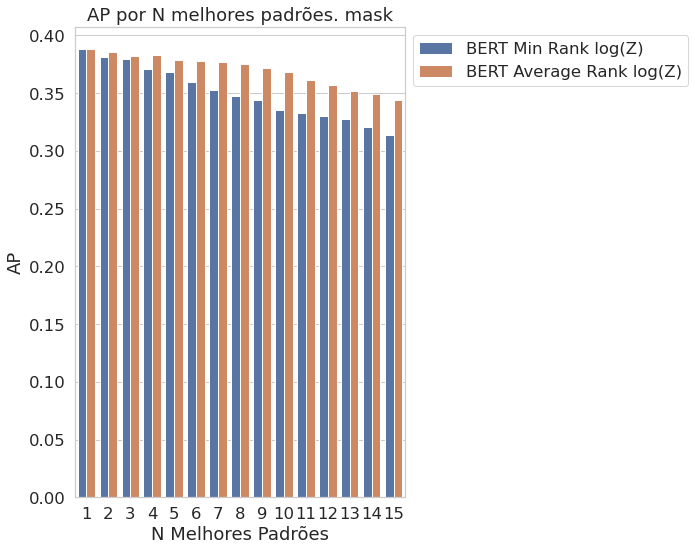

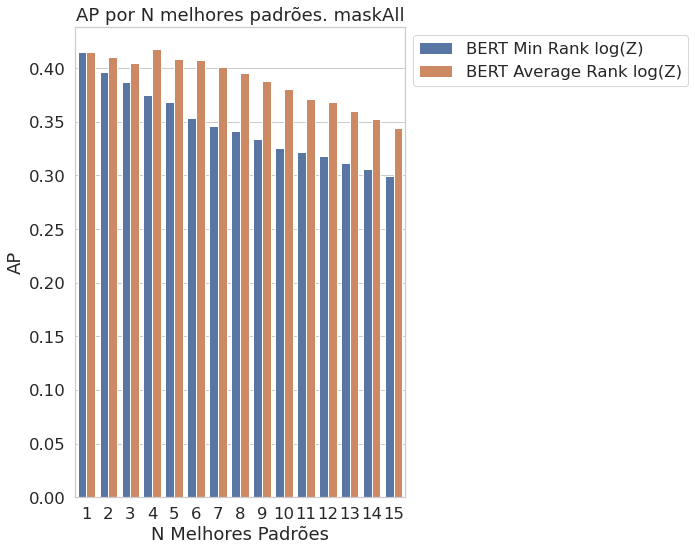

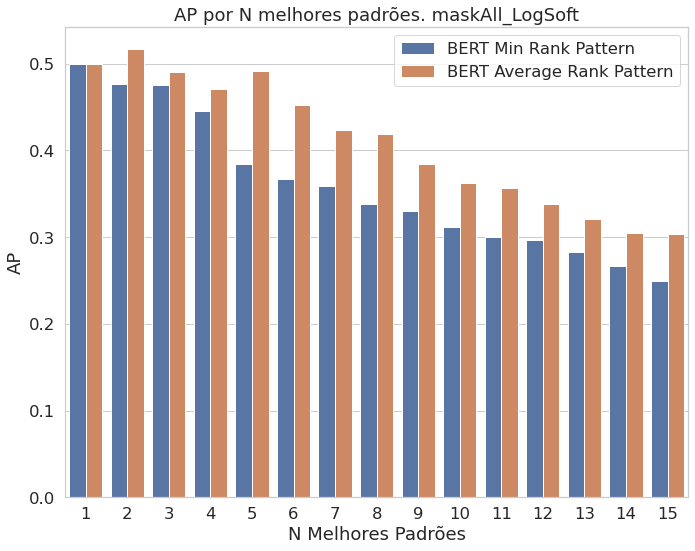

In [5]:
# AP por N melhores padroes DEV EN
# AP por n-rank
for mask_type, df_with_oov in dfs_data.items():
    if mask_type == "mask":
        column_sort = "score_final_log(z)"
    elif mask_type == "maskAll":
        column_sort = "score_final_log(z)"
    elif mask_type == "maskAll_LogSoft":
        column_sort = "score_pattern_mean"
    else:
        raise KeyError
    df_plot = nb_utils.compute_AP_n_best_pattern(df_with_oov, 
                                                 key_sort=column_sort, 
                                                 n_best_pattern=best_pattern[mask_type])
    df_plot['method_format'] = df_plot['method'].map(nb_utils.get_method_name_ijcai())
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(data=df_plot, x='n_best_pattern', y='AP', hue='method_format')
    ax.set(xlabel="N Melhores Padrões")
    ax.set_title(f"AP por N melhores padrões. {mask_type}")
    ax.legend(bbox_to_anchor=(1, 1))
    plt.show()

### DEV - Inglês
#### Dados do gráfico acima, para visualização em números

In [6]:
# # Dados dos gŕaficos acima.
# df_mean = df_plot[df_plot['method'] == 'mean score_pattern_mean']
# df_mean = df_mean.sort_values(by='AP', ascending=False)
# print(f"Melhor combinação de Melhores Padrões usando Média dos ranks entre eles")
# print(df_mean.iloc[:4])

# print(f"Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles")
# df_min = df_plot[df_plot['method'] == 'min score_pattern_mean']
# df_min = df_min.sort_values(by='AP', ascending=False)
# print(df_min.iloc[:4])

In [7]:
# # Balanceamento true/false
# # balanceamento do dataset inteiro
# df_size = nb_utils.balanceamento_all(df_with_oov, patterns=pattern_unique)
# print(df_size)

In [8]:
%reset_selective -f json_
%reset_selective -f ax
%reset_selective -f path

----------------

# Datasets Test - 10 datasets em inglês
### Usando os melhores padrões do HypeNet-train

In [9]:
# processo demorado
if local:
    path_json_normal = "../../aaaaaaaa/test-mask-pattern/"
else:
    bert_mask = "../../en-model/bert-base-uncased_bert_score_normal_2020-11-12_15:13:01"
    bert_mask_all = "../../en-model/bert-base-uncased_bert_score_maskall_2021-03-22_23:29:19"
    # alterar
    bert_mask_all_logsoftmax = "../../en-model/bert-base-uncased_bert_score_maskall_2021-03-23_12:26:19"
len_total_unique = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

dfs = {}
pattern_unique = {}
filename = ""

# dfs_data['mask'] 
# dfs_data['maskAll'] 
# dfs_data['maskAll_LogSoft']

# mask
for filename in os.listdir(bert_mask):
    if os.path.isfile(os.path.join(bert_mask, filename)) and filename.endswith(".json"):
        df = nb_utils.create_dataframe(json.load(open(os.path.join(bert_mask, filename))), combination=False, separator="\t")
        pattern = df['pattern'].unique().tolist()
        df = nb_utils.logsumexp_normalization(df, len_list=len_total_unique, 
                                              pattern_list=pattern)
        df['tipo'] = 'mask'
        dfs[filename + " mask"] = df

#maskAll
for filename in os.listdir(bert_mask_all):
    if os.path.isfile(os.path.join(bert_mask_all, filename)) and filename.endswith(".json"):
        df = nb_utils.create_dataframe_maskAll(json.load(open(os.path.join(bert_mask_all, filename))), separator="\t")
        pattern = df['pattern'].unique().tolist()
        df = nb_utils.logsumexp_normalization(df, len_list=len_total_unique, 
                                              pattern_list=pattern)
        df['tipo'] = 'maskAll'
        dfs[filename + " maskAll"] = df

#maskAll_LogSoft
for filename in os.listdir(bert_mask_all_logsoftmax):
    if os.path.isfile(os.path.join(bert_mask_all_logsoftmax, filename)) and filename.endswith(".json"):
        df = nb_utils.create_dataframe_maskAll_pattern(json.load(open(os.path.join(bert_mask_all_logsoftmax, filename))), separator="\t")
        pattern = df['pattern'].unique().tolist()
        df['tipo'] = 'maskAll_LogSoft'
        dfs[filename + " maskAll_LogSoft"] = df

        
    
# for filename in os.listdir(path_json_normal):
#     if os.path.isfile(os.path.join(path_json_normal, filename)) and filename.endswith(".json"):
#         df = nb_utils.create_dataframe_maskAll_pattern(json.load(open(os.path.join(path_json_normal, filename))), separator="\t")
#         pattern = df['pattern'].unique().tolist()
#         df = nb_utils.logsumexp_normalization(df, len_list=len_total_unique, 
#                                               pattern_list=pattern)

#         df['tipo'] = 'normal'
#         dfs[filename + " normal"] = df
# pattern_unique['normal'] = 
# pattern_unique = pattern_unique['normal']
print("Processamento Pronto!")

Processamento Pronto!


In [10]:
df_ratios = []
for dataset_name in dfs.keys():
    print(dataset_name)
    dname, type_dataset = dataset_name.split()
    len_total_unique = dfs[dataset_name]['len_total'].unique().tolist()
    df_ratio = nb_utils.balanceamento(dfs[dataset_name], len_size=len_total_unique,
                                      patterns=best_pattern[type_dataset])
    df_ratio['dataset'] = dname
    df_ratio['tipo'] = type_dataset
    df_ratios.append(df_ratio)
df_ratios = pd.concat(df_ratios, ignore_index=True)
print("Processamento pronto")

wordnet_test.json mask
baroni2012.json mask
HypeNet_test.json mask
Weeds.json mask
kotlerman2010.json mask
EVALution.json mask
LenciBenotto.json mask
BLESS.json mask
levy2014.json mask
turney2014.json mask
wordnet_test.json maskAll
baroni2012.json maskAll
HypeNet_test.json maskAll
Weeds.json maskAll
kotlerman2010.json maskAll
EVALution.json maskAll
LenciBenotto.json maskAll
BLESS.json maskAll
levy2014.json maskAll
turney2014.json maskAll
wordnet_test.json maskAll_LogSoft
baroni2012.json maskAll_LogSoft
HypeNet_test.json maskAll_LogSoft
Weeds.json maskAll_LogSoft
kotlerman2010.json maskAll_LogSoft
EVALution.json maskAll_LogSoft
LenciBenotto.json maskAll_LogSoft
BLESS.json maskAll_LogSoft
levy2014.json maskAll_LogSoft
turney2014.json maskAll_LogSoft
Processamento pronto


In [11]:
df_ratios['dataset_format'] = df_ratios['dataset'].map(nb_utils.get_dataset_names())
df_ratios['dataset_tipo'] = df_ratios['dataset_format'] + " " + df_ratios['tipo']
df_ratios['ratio_percent'] = df_ratios['ratio'] * 100
df_ratios['total'] = df_ratios['true'] + df_ratios['false']
df_plot_lensubtoken = df_ratios[df_ratios['tipo'] == 'normal']

### Test - inglês 10 datasets
#### Stats
 - Eixo X: Comprimento do par
 - Eixo Y: Porcentagem de pares verdadeiros para cada comprimento
 - OBS: Eixo Y não é compartilhado, para facilitar a visualização


In [12]:
# best_pattern_train = ['{} is a {}', '{} or some other {}', '{} and some other {}', '{} or any other {}', '{} , a {}', '{} which is a class of {}', '{} is a type of {}', '{} and any other {}', '{} or others {}', '{} and others {}', '{} which is kind of {}', '{} including {}', '{} a special case of {}', '{} which is a example of {}', '{} which is called {}']
# dfs_data['mask'] 
# dfs_data['maskAll'] 
# dfs_data['maskAll_LogSoft']
dfs2 = []

best_pattern_num_train = 4
for count_best_pattern in range(1, best_pattern_num_train + 1):
    for dataset_name in dfs.keys():
        dname, type_dataset = dataset_name.split()
        # type_dataset == 'mask', 'maskAll', 'maskAll_LogSoft'
        if type_dataset == "mask":
            df_temp= nb_utils.compute_min_mean_ap_normal(dfs[dataset_name],
                                                         pattern_list=best_pattern[type_dataset], 
                                                         dataset_name=dname, 
                                                         best_pattern_num=count_best_pattern)
            df_temp['tipo'] = type_dataset
            df_temp['pattern_num'] = count_best_pattern
            dfs2.append(df_temp)
        elif type_dataset == "maskAll":
            df_temp= nb_utils.compute_min_mean_ap_normal(dfs[dataset_name], 
                                                         pattern_list=best_pattern[type_dataset], 
                                                         dataset_name=dname, 
                                                         best_pattern_num=count_best_pattern)
            df_temp['tipo'] = type_dataset
            df_temp['pattern_num'] = count_best_pattern
            dfs2.append(df_temp)
        elif type_dataset == 'maskAll_LogSoft':
            df_temp= nb_utils.compute_min_mean_ap_normal(dfs[dataset_name], 
                                                         pattern_list=best_pattern[type_dataset], 
                                                         dataset_name=dname, 
                                                         best_pattern_num=count_best_pattern)
            df_temp['tipo'] = type_dataset
            df_temp['pattern_num'] = count_best_pattern
            dfs2.append(df_temp)
            # df_temp = nb_utils.compute_ap_bert_soma(dfs[dataset_name], pattern_list=best_pattern_train, dataset_name=dname,
            #                                         best_pattern_num=count_best_pattern, tipo='normal', column_sort="score_pattern_mean")
            # df_temp['tipo'] = "normal"
            # df_temp['pattern_num'] = count_best_pattern
            # dfs2.append(df_temp)
df_en = pd.concat(dfs2)
print("Processo terminado!")
# df_en = df_en[df_en['method'].isin(['min score_pattern_mean', 'mean score_pattern_mean'])]

Processo terminado!


### Test
### AP para cada método (BERT, DIVE e Word2vec)
#### Usando BERT - Log(Z) mascarando todos os tokens e também só os pares
#### Usando log_softmax mascarando apenas os pares do padrão
 - Ordem dos algoritmo na legenda:
    - Pattern maskAll_LogSoft = mascarar apenas os tokens do padrão, pegar o logsoftmax e dividir pela quantidade de tokens do padrão
    
    - log(Z) mask = logits do par somados - log(Z)
    
    - log(Z) maskAll = logits de todos os tokens da sentença somados - log(Z)

    - Average e Min são as estratégias de combinar padrões
         com @ K melhores padrões

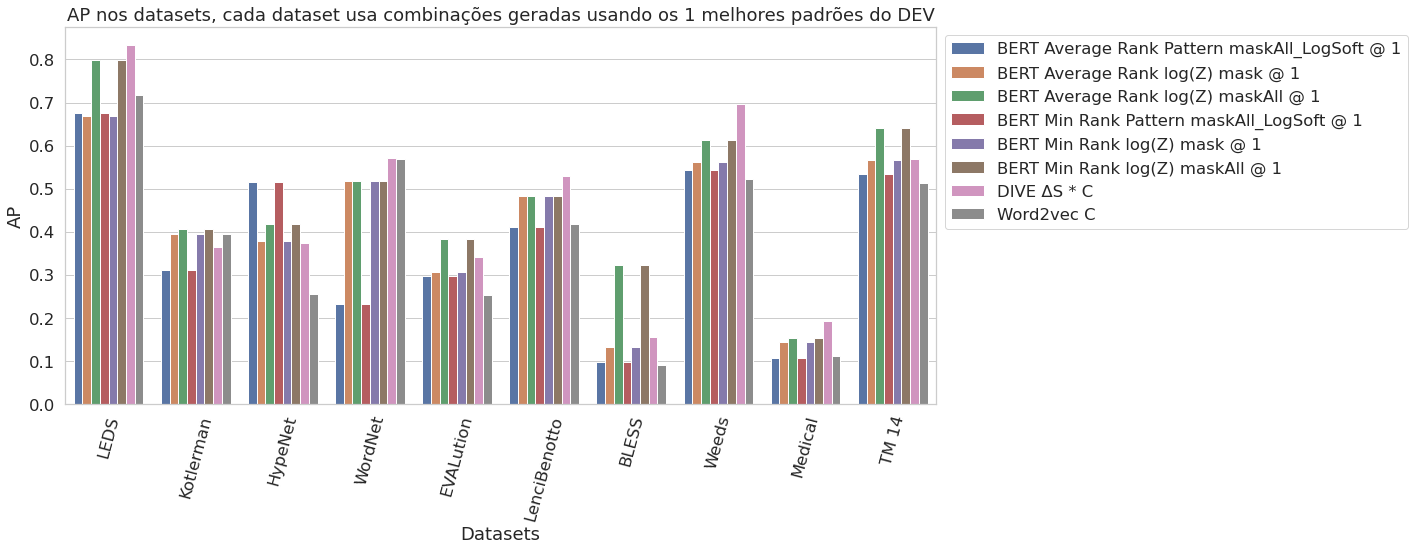

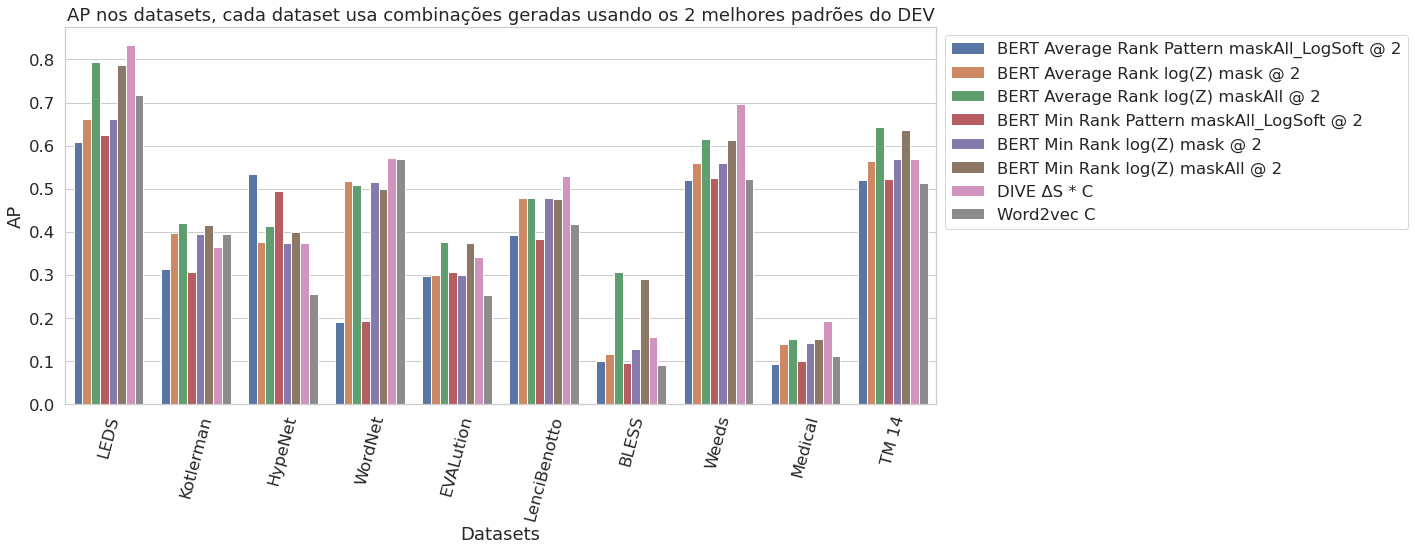

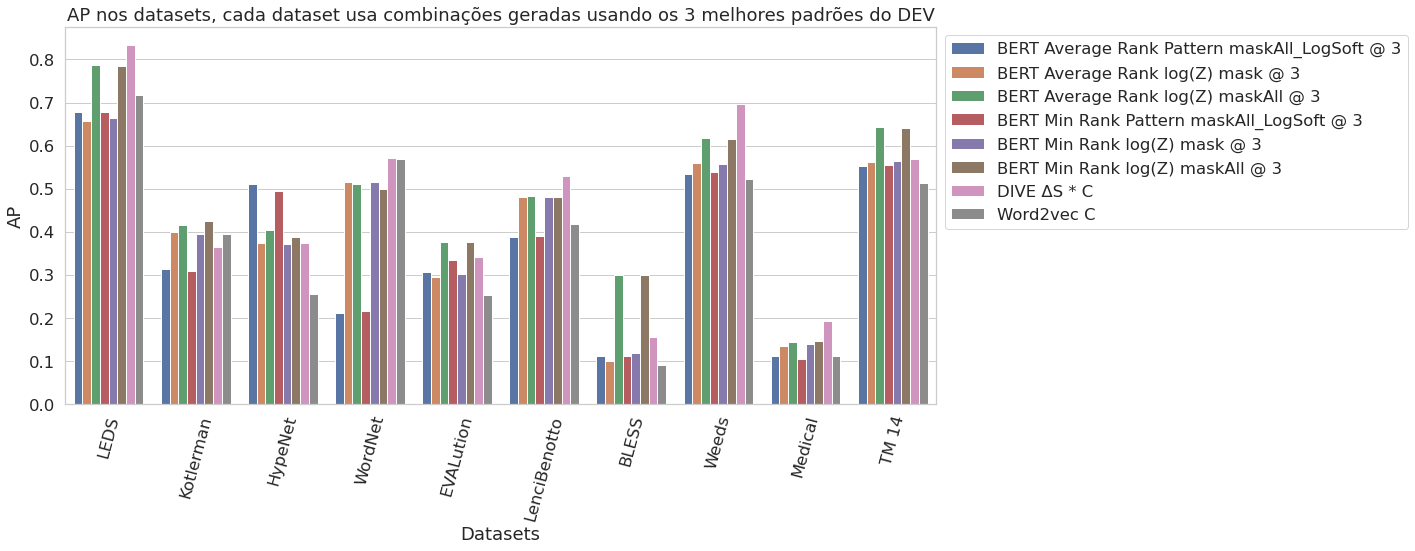

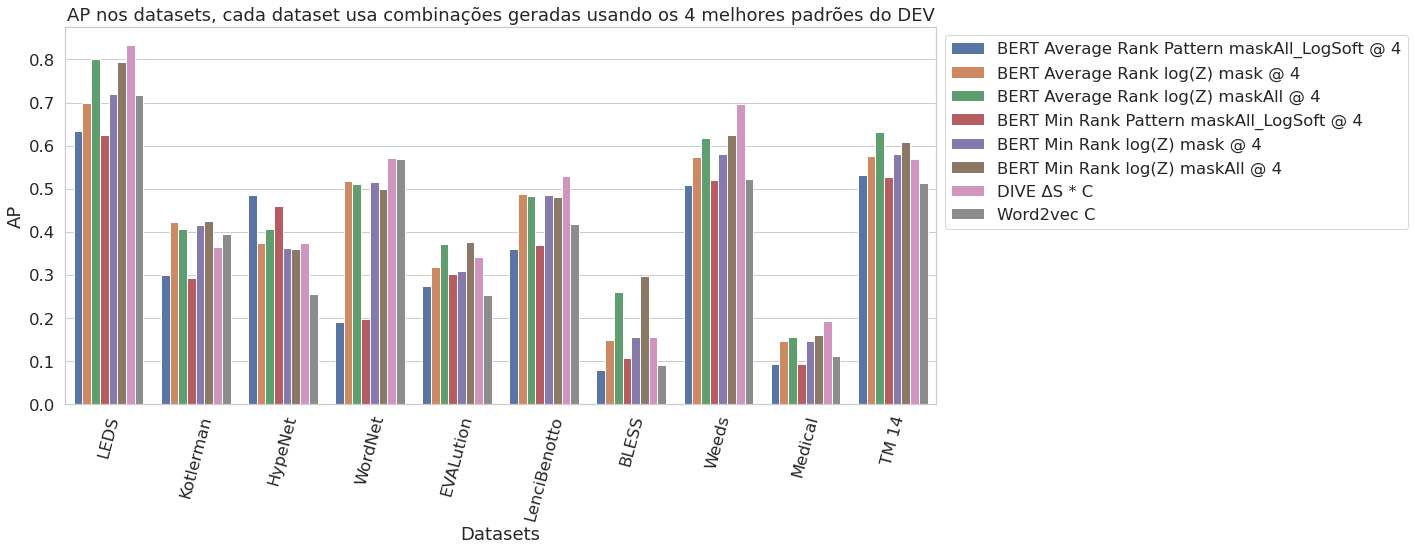

In [13]:
df_dive = nb_utils.get_df_dive()
df_dive['method_format_tipo'] = df_dive['method'].map(nb_utils.get_method_name_ijcai())

#pegar apenas BERT e Dive/w2v
# normal == bert
# logZ == bert - logZ
df_dissertacao = df_en.copy()

# AP por método
df_dissertacao['method_format_tipo'] = df_dissertacao['method_format'].map(nb_utils.get_method_name_ijcai())
df_dissertacao['method_format_tipo'] += " " + df_dissertacao['tipo'] 
df_dissertacao['method_format_tipo'] += " @ " + df_dissertacao['pattern_num'].astype('str')
# print(df_dissertacao['method_format_tipo'])

pattern_num_unique = df_dissertacao['pattern_num'].unique().tolist()

for p_num in pattern_num_unique:
    dfPlot = df_dissertacao[df_dissertacao['pattern_num'] == p_num]
    dfPlot = pd.concat([dfPlot, df_dive])
    dfPlot['dataset_format'] = dfPlot['dataset'].map(nb_utils.get_dataset_names())
    dfPlot = dfPlot.sort_values('method_format_tipo')
    plt.figure(figsize=(20,8))
    ax = sns.barplot(x='dataset_format' ,hue="method_format_tipo", 
                     y="AP", ci="sd",data=dfPlot)
    ax.set(xlabel="Datasets")
    ax.set_title(f"AP nos datasets, cada dataset usa combinações geradas usando os {p_num} melhores"
                 f" padrões do DEV")
    ax.legend(bbox_to_anchor=(1, 1))
    legend = ax.get_legend()
    _ = plt.xticks(rotation=75)
    # plt.savefig('fig_ap_datasetsEn_p2.pdf')
    plt.show()


# plt.figure(figsize=(20,8)) # this creates a figure 8 inch wide, 4 inch high
# g = sns.catplot(x="method_format_tipo", y="AP", col="dataset", col_wrap=5,
#                 data=df_dissertacao, saturation=.5,
#                 kind="bar", ci="sd", aspect=.9, legend='full')
# (g.set_axis_labels("", "AP")
#     .set_xticklabels(rotation=40, ha="right")
#     .set_titles("{col_name}"))
# plt.subplots_adjust(top=0.9, hspace=0.3)
# _ = g.fig.suptitle('Mesmo gráfico de cima')
# plt.show()

### Test - inglês 10 datasets
#### Stats
 - Dados dos gráficos acima para exportar e vizualizar
 - Não funcional

In [14]:
# dados dos graficos acima
# salvar CSV e fazer rank medio dos métodos
# print contagem
df_print = df_ratios.groupby(['dataset', 'tipo']).sum()[['true', 'false', 'total']]
df_print['ratio'] = df_print['true'] / df_print['total']
print(df_print)
#
# # df to csv
# df_dissertacao['dataset_format'] = df_dissertacao['dataset'].map(nb_utils.get_dataset_names())
# group_list = ['dataset_format', 'AP', 'tipo','method_format_tipo', 'N', 'hyper_num', 'pattern_num']
# methods_avg_list = ['BERT Min Rank Pattern @ 1', 'BERT Average Rank Pattern @ 1',
#                     'BERT Min Rank log(Z) logZ @ 2', 'BERT Average Rank log(Z) logZ @ 2',
#                     'BERT Min Rank log(Z) logZ @ 3', 'BERT Average Rank log(Z) logZ @ 3',
#                     'BERT Min Rank log(Z) logZ @ 4', 'BERT Average Rank log(Z) logZ @ 4',
#                     'Word2vec C', 'DIVE ΔS * C ']
#
#
# df_csv = df_dissertacao[group_list]
# df_csv = df_csv.sort_values(by=group_list[:2])
# df_csv['AP'] = df_csv['AP'] * 100
# df_csv['AP'] = df_csv['AP'].round(2)
# # print(df_csv[df_csv['dataset_format'] == "Medical"])
# table = pd.pivot_table(df_csv, values='AP', index="dataset_format", columns=['method_format_tipo'])
# # print(table)
# tableT = table.copy()
# # tableT = tableT.set_index('dataset_format')
# tableT = tableT[methods_avg_list]
# tableT = tableT.T
# rank = pd.DataFrame()
# for c in tableT.columns:
#     rank[c] = tableT[c].rank(method="min", ascending=False)
# rank['avg'] = rank.mean(axis=1)
# rank = rank.sort_index()
# table.to_csv("datasets_ingles_bert_dive_word2vec_4_padroes_maskall",index=True)
# rank.to_csv("datasets_ingles_bert_dive_word2vec_4_padroes_maskall_AVG",index=True)

                                    true  false  total     ratio
dataset            tipo                                         
BLESS.json         mask             1337  25195  26532  0.050392
                   maskAll          1337  25195  26532  0.050392
                   maskAll_LogSoft  1337  25195  26532  0.050392
EVALution.json     mask             1911   5196   7107  0.268890
                   maskAll          1911   5196   7107  0.268890
                   maskAll_LogSoft  1911   5196   7107  0.268890
HypeNet_test.json  mask             3512  14158  17670  0.198755
                   maskAll          3512  14158  17670  0.198755
                   maskAll_LogSoft  3512  14158  17670  0.198755
LenciBenotto.json  mask             1933   3077   5010  0.385828
                   maskAll          1933   3077   5010  0.385828
                   maskAll_LogSoft  1933   3077   5010  0.385828
Weeds.json         mask             1119   1114   2233  0.501120
                   maskAl

In [15]:
# reset
# %reset_selective -f df
# %reset_selective -f json_
# %reset_selective -f ax
# %reset_selective -f path
# %reset_selective -f best
# %reset_selective -f max_
# %reset_selective -f pattern